In [1]:
import keras_core as ks
from keras_core import ops
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
from kgcnn.literature.GCN import make_model
from kgcnn.data.utils import ragged_tensor_from_nested_numpy
from kgcnn.training.scheduler import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.MutagenicityDataset import MutagenicityDataset

Using TensorFlow backend


## Load Data

In [2]:
model_inputs = [
    {'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32'},
    {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32'},
    {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64'},
    {"shape": (), "name": "total_nodes", "dtype": "int64"},
    {"shape": (), "name": "total_edges", "dtype": "int64"}
]

In [3]:
dataset = MutagenicityDataset()
dataset.map_list(method="count_nodes_and_edges")
for i in range(len(dataset)):
    # Make edge feature dimension
    dataset[i]["edge_attributes"] = np.expand_dims(dataset[i]["edge_attributes"], axis=-1).astype(np.float32)
    # Make One-Hot encoding
    dataset[i]["node_attributes"] = np.array(np.expand_dims(dataset[i]["node_attributes"] ,axis=-1) == np.array(
        [[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]]), dtype="int") 
train_indices, test_indices = train_test_split(np.arange(len(dataset)),  train_size=0.8, random_state=1)
dataset_train, dataset_test = dataset[train_indices], dataset[test_indices]
xtrain = dataset_train.tensor(model_inputs)
xtest = dataset_test.tensor(model_inputs)
ytrain = dataset_train.tensor({"name": "graph_labels"})
ytest = dataset_test.tensor({"name": "graph_labels"})
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name Mutagenicity
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.
INFO:kgcnn.data.Mutagenicity:Reading dataset to memory with name Mutagenicity
INFO:kgcnn.data.Mutagenicity:Shift start of graph ID to zero for 'Mutagenicity' to match python indexing.
INFO:kgcnn.data.Mutagenicity:Graph index which has unconnected '[  38  133  166  171  220  246  268  278  286  296  302  305  309  339
  357  439  470  497  527  706  743  783  815  861  878  902  918 1029
 1040 1044 1057 1085 1193 1233 1329 1394 1431 1525 1528 1532 1609 1645
 1696 1915 1971 2024 2026 2036 2069 2133 2138 2142 2143 2174 2193 2210
 2234 2258 2360 2422 2440 2471 2482 2483 2503 2553 2559 2604 2627 26

[(3469, 103, 14), (3469, 216, 1), (3469, 216, 2), (3469,), (3469,)]
[(868, 99, 14), (868, 224, 1), (868, 224, 2), (868,), (868,)]
(3469, 1) (868, 1)


## Make and train a GCN

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'GCN', 'inputs': [{'shape': (None, 14), 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'input_embedding': None, 'cast_disjoint_kwargs': {}, 'input_node_embedding': {'input_dim': 55, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 10, 'output_dim': 64}, 'gcn_args': {'units': 64, 'use_bias': True, 'activation': 'relu', 'pooling_method': 'scatter_mean', 'normalize_by_weights': False}, 'depth': 3, 'verbose': 10, 'node_pooling_args': {'pooling_method': 'scatter_sum'}, 'output_embedding': 'graph', 'output_to_tensor': None, 'output_tensor_type': 'padded', 'output_mlp': {'use_bias': [True, True, False], 'units': [140, 70, 1], 'activation': ['relu', 'relu', 

Model: "GCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 14)          │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 14), (None),      │           0 │ node_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 1)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 14), (2, None),   │           0 │ node_attributes[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ edge_indices[0][0],            │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │         960 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 1), (None),       │           0 │ edge_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn (GCN)                     │ (None, 64)                │       4,160 │ dense[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_1 (GCN)                   │ (None, 64)                │       4,160 │ gcn[0][0],                     │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_2 (GCN)                   │ (None, 64)                │       4,160 │ gcn_1[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ 

 Total params: 32,480 (126.88 KB)

 Trainable params: 32,480 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Print Time for taining:  402.5625


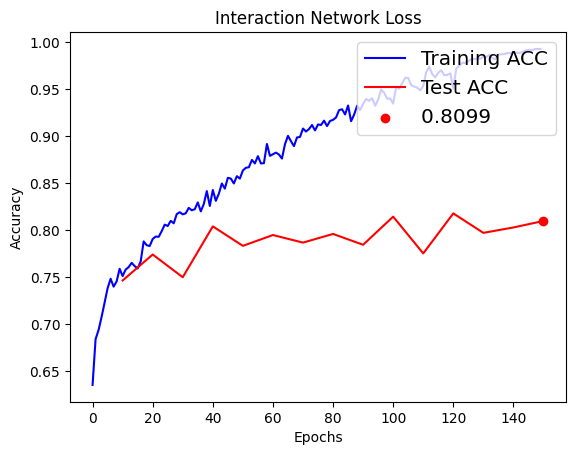

In [4]:
model = make_model(
    name = "GCN",
    inputs = model_inputs,
    input_node_embedding = {"input_dim": 55, "output_dim": 64},
    input_edge_embedding = {"input_dim": 10, "output_dim": 64},
    gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'scatter_mean', 
                "normalize_by_weights": False},
    output_embedding =  'graph',
    output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']},
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = ks.optimizers.Adam(learning_rate=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=0
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag.png')
plt.show()

## Implementation of the  ExplainableGCN from GNNInterface

In [5]:
# Now we have to implement the ExplainableGCN
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input, node_len, edge_len = gnn_input

        node_len = ops.convert_to_tensor(node_len)
        edge_len = ops.convert_to_tensor(edge_len)
        edge_index_input = ops.convert_to_tensor(edge_index_input)
        masked_edge_input = ops.convert_to_tensor(edge_input) * ops.cast(edge_mask, dtype="float32")
        masked_feature_input = ops.convert_to_tensor(node_input) * ops.cast(ops.transpose(feature_mask), dtype="float32")
        
        masked_node_feature_input = ops.convert_to_tensor(masked_feature_input) * ops.cast(node_mask, dtype="float32")
        masked_pred = \
        self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input, node_len, edge_len], training=training)[0]

        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        return gnn_input[0][0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        return gnn_input[0].shape[2]

    def get_number_of_edges(self, gnn_input):
        return gnn_input[1][0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        num_nodes = gnn_input[3][0]
        num_edges = gnn_input[4][0]
        graph = nx.Graph()
        for i in range(num_nodes):
            f = features[i]
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i in range(num_edges):
            e = edges[i]
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [6]:
explainable_gcn = ExplainableGCN(model)
compile_options = {'loss': 'binary_crossentropy', 'optimizer': ks.optimizers.Adam(learning_rate=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

Explain Single Instance and check setup:

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras_core\src\optimizers\base_optimizer.py:430: UserWarning: Gradients do not exist for variables ['feature_mask', 'node_mask'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


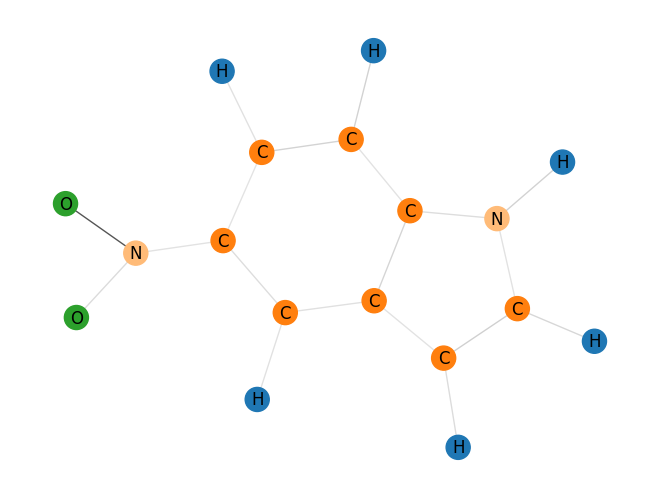

In [7]:
inspection_result = explainer.explain([tensor[776:777] for tensor in xtest], inspection=True)
# inspection_result = explainer.explain([tensor[264:265] for tensor in xtest], output_to_explain=tf.Variable([0.]), inspection=True)

# Present explanation
plt.figure()
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()

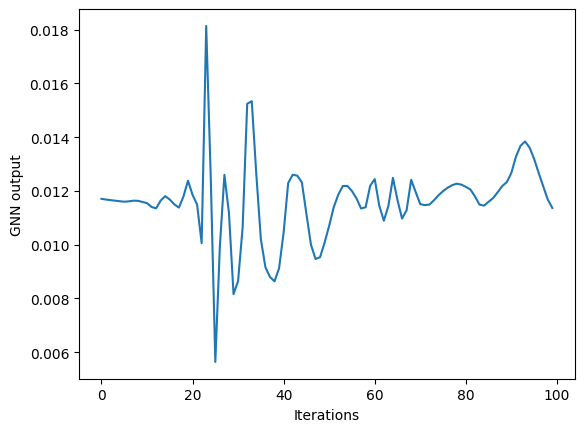

In [8]:
# Predictions
plt.figure()
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')
plt.show()

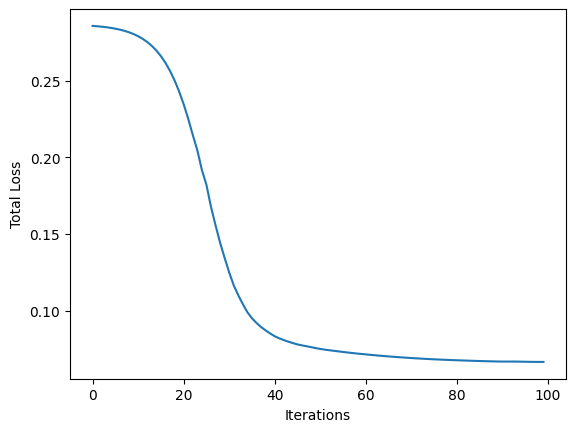

In [9]:
# loss
plt.figure()
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.show()

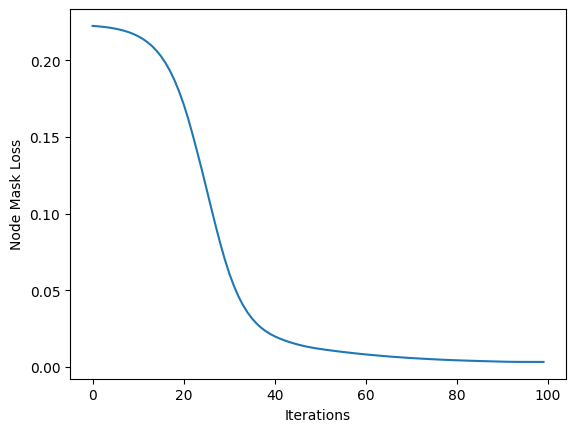

In [10]:
# edge loss
plt.figure()
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')
plt.show()